# Computational Social Science Project #2 

**Enter your Name:** Vo Ram Yoon

*Semester:* Fall 2025

Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [127]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import Ridge, Lasso, LinearRegression


# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the project folder: "Diabetes with Population Info by County 2017.csv".

In [128]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv('Diabetes with Population Info by County 2017.csv', 
                       dtype={"CountyFIPS": str}) 

In [129]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [130]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [131]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [132]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique()) 

['No Data']


In [133]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique()) 

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [134]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 


# Physical Inactivity
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 


# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float)

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [135]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [136]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [137]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population_65 years and over_1',
 'race_total population_two or more races_1',
 'race_total population_one race_1',
 'sex and age_total population',
 'sex and age_total population_18 years and over_1',
 'hispanic or latino and race_total population']

In [138]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [139]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

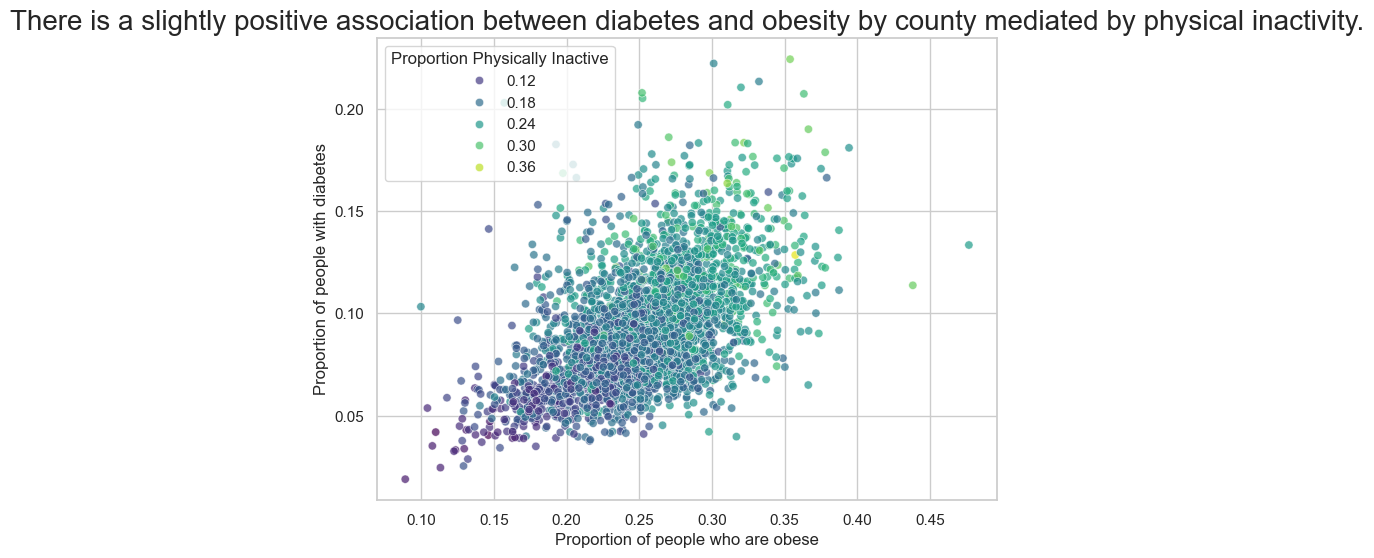

In [140]:
#
# EDA #1 and interpretations in this section 

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(
    y="Diabetes_Number",
    x="Obesity_Number",
    hue="Physical_Inactivity_Number",
    data=diabetes,
    palette="viridis",  # or "coolwarm", "magma", etc.
    alpha=0.7
)
plt.legend(title='Proportion Physically Inactive')
plt.title("There is a slightly positive association between diabetes and obesity by county mediated by physical inactivity.", fontsize=20)
plt.ylabel("Proportion of people with diabetes by county")
plt.xlabel("Proportion of people who are obese by county")
plt.show()

# Overall, this graph shows that counties with lower proportions of people who are obese tend to have lower proportions of people who have diabetes.
# The association is influenced by people's level of physical inactivity, as demonstrated by how the darker dots in the lower left quadrant represent
# counties with people who are more physically active and are less likely to be obese and have diabetes. To develop policies and programs aimed at
# reducing the prevalence of diabetes, local policymakers could consider programs focusing on making healthier diets and exercise more accessible.

In [141]:
#
# EDA #2 and interpretations in this section 

state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

diabetes["state_abbrev"] = diabetes["State"].map(state_abbrev)

state_avg = diabetes.groupby("state_abbrev")["Diabetes_Number"].mean().reset_index()

fig = px.choropleth(
    state_avg,
    locations="state_abbrev",
    locationmode= "USA-states",
    color="Diabetes_Number",
    scope="usa",
    color_continuous_scale="Reds",
    title="The average proportion of diabetes by state is higher in Southern states compared to other regions.",
    labels={"Diabetes_Number": "Proportion of Diabetes"}
)
fig.show()


# This map demonstrates that diabetes is more prevalent in states in the South. especially Alabama, compared to states in other regions in the U.S. 
# To address the prevalance of diabetes in the U.S., it is important for policymakers to customize interventions based on local needs since areas
# with higher rates of diabetes might need more intensive programs and policies compared to areas where people face less barriers to adopting
# healthier lifestyles.

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [142]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
#we also did this for states
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ['state_abbrev','Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [143]:
#
# Partition data

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes["Diabetes_Number"]

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(['Diabetes_Number','race alone or in combination with one or more other races_total population'],
                       axis = 1)


Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [144]:
X.head()

,CountyFIPS,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race - and three or more races,total housing units,citizen - voting age population_citizen - 18 a

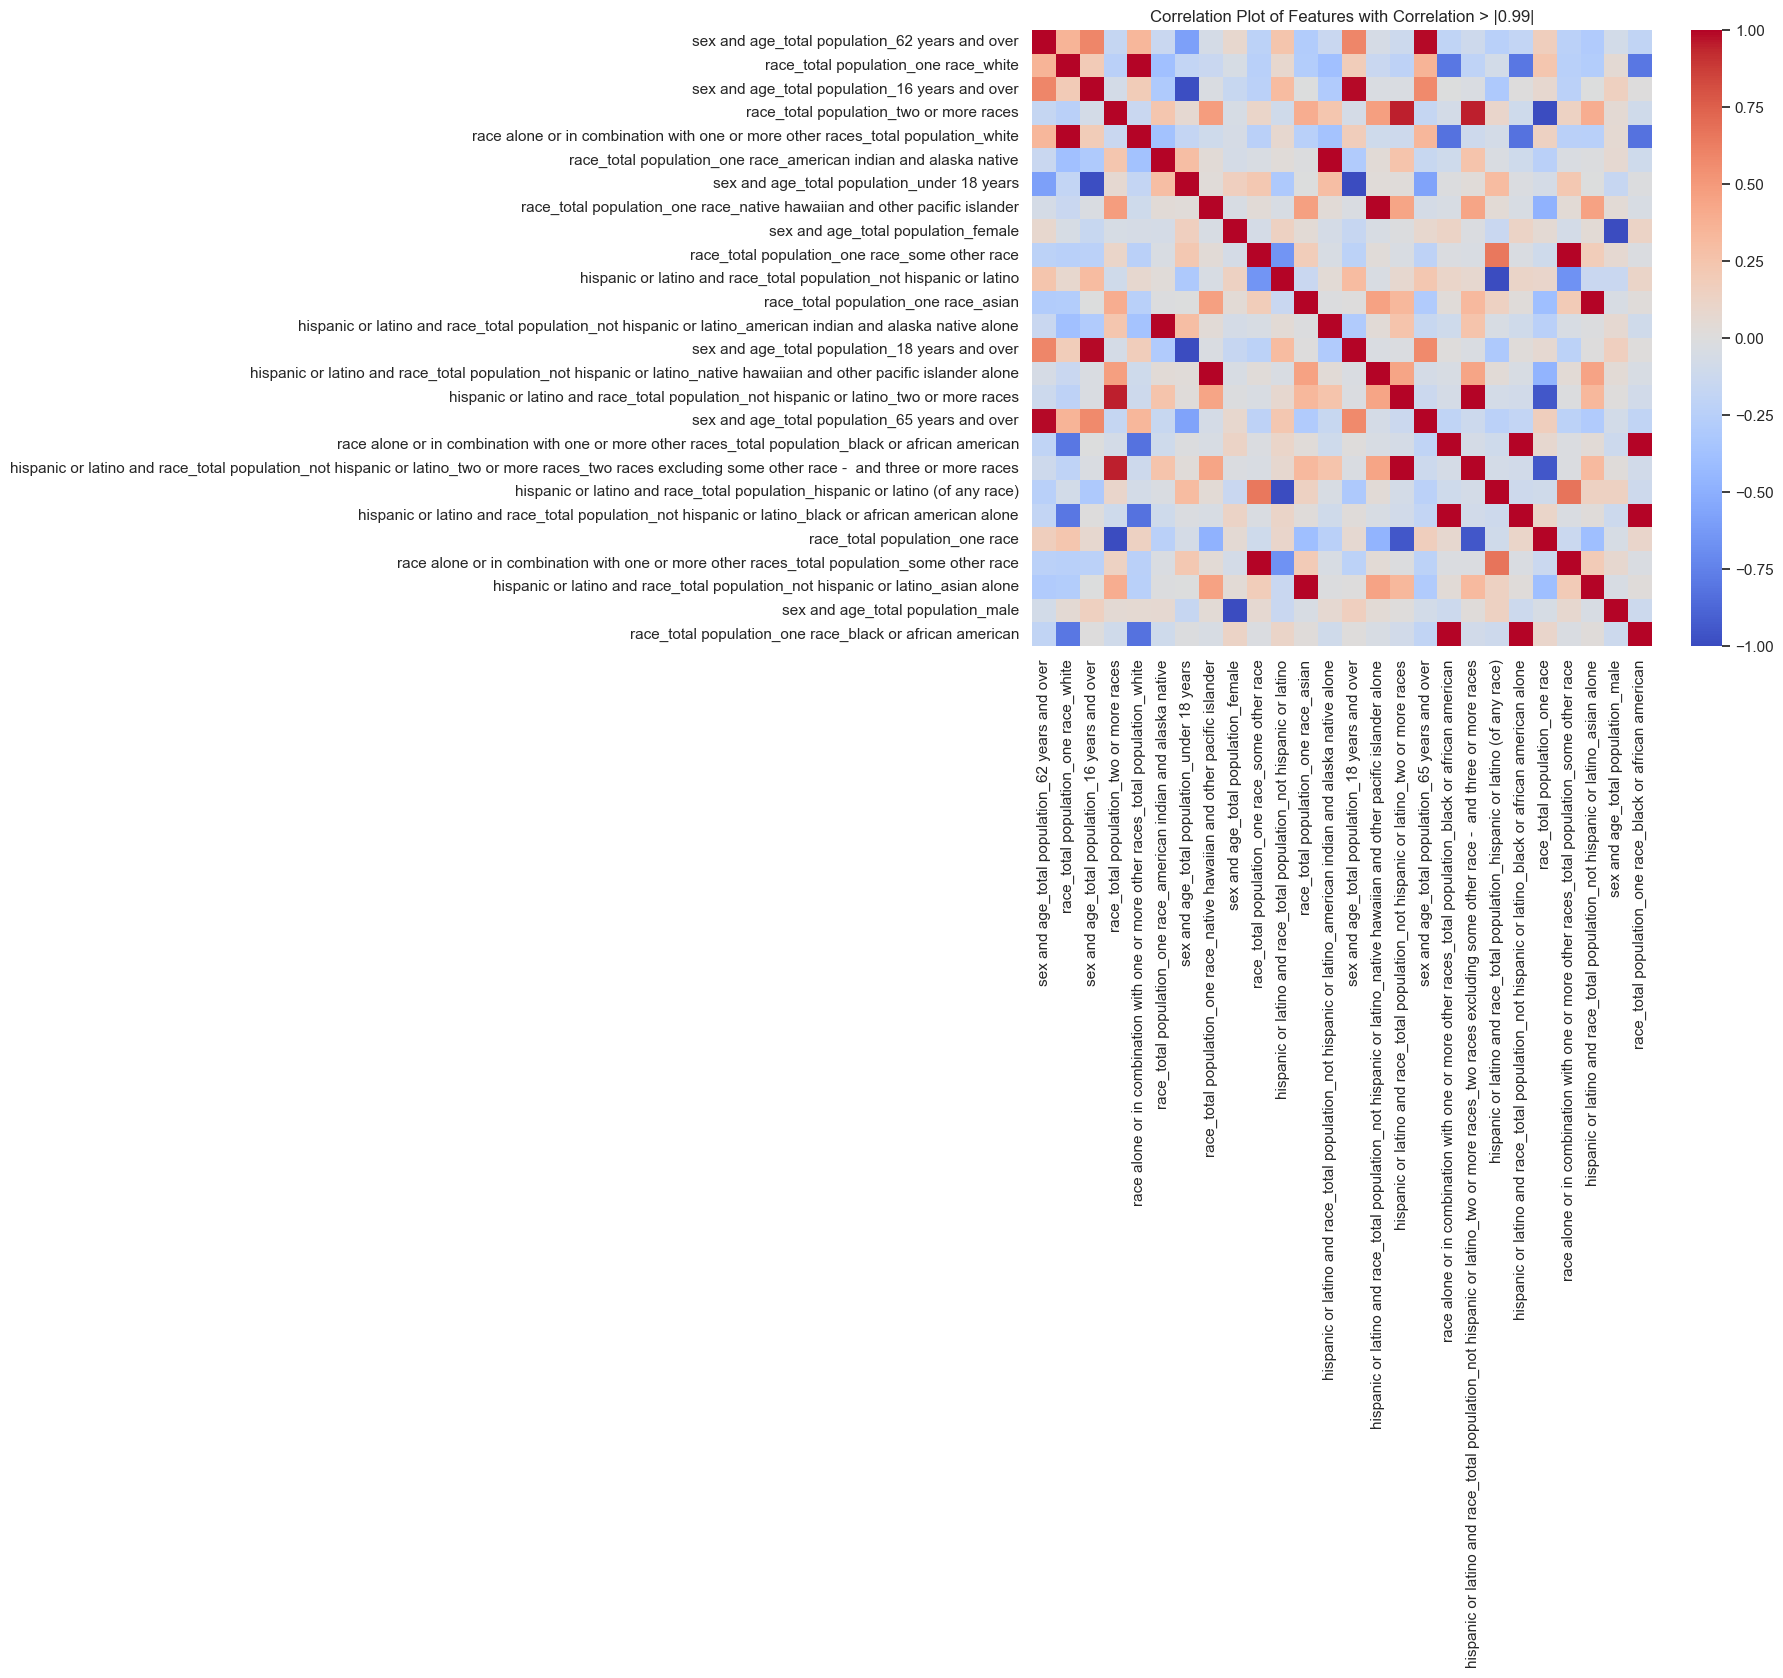

In [145]:
#
# Feature selection
#-----------
X = X.drop(labels = ['CountyFIPS'],axis = 1)

corr_matrix = X.corr()
threshold = 0.99
filtered_corr = corr_matrix[np.abs(corr_matrix) > threshold]

highly_correlated_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if np.abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            highly_correlated_pairs.append((colname_i, colname_j))
            
high_corr_features = set()
for pair in highly_correlated_pairs:
    high_corr_features.add(pair[0])
    high_corr_features.add(pair[1])

if not high_corr_features:
    print("\nNo features found with a correlation > 0.99.")
else:
    # Create a new DataFrame containing only the highly correlated features
    subset_df = X[list(high_corr_features)]
    
    # Calculate the correlation matrix for the subset
    subset_corr_matrix = subset_df.corr()
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(subset_corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Plot of Features with Correlation > |{threshold}|')
    plt.show()




In [146]:
variance_per_column = X.var()

print(np.mean(variance_per_column==0))

0.0


We drop one variable (`CountyFIPS`). We initially thought to remove the `state_abbrev` feature as we only created this for EDA visualization. However, from EDA map visualization, we see that state membership may be a strong predictor of diabetes burden, so we one-hot encode the `state_abbrev` variable. We removed `CountyFIPS`, as while it was numeric, it is just an ID variable and its numeric value is meaningless. If we had multiple records per county (e.g. multiple years of data), we could convert `CountyFIPS` to string and then one-hot encode it, essentially introducing fixed effect predictors for county. We do not do this here as we do not have the data support. 

There are a few variables that are very strongly correlated, such as `sex and age_total_population_male` and `sex and age_total_population_female` and `race_total population_one_race_some other race` and `race alone or in combination with one or more other races_total_population_some other race`. It could be worth dropping one variable from each pair, but we would rather run models that have some ability to screen out highly correlated variables (e.g. Lasso) and see their performance rather than choose variables to exclude at this stage. 

We also see that there are no variables that have zero variance in our data. If a variable was constant across all observations, it would provide no predictive power, but we do not any such cases. 

In [147]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 
                                                    y,                 
                                                    train_size=0.80,      
                                                    test_size=0.20)       

In [148]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,         
                                                            y_train,        
                                                            train_size=0.75,
                                                            test_size=0.25)

print("Shape of X train is", X_train.shape)
print("Shape of X_validate is", X_validate.shape)
print("Shape of X_test is", X_test.shape)

Shape of X train is (1866, 137)
Shape of X_validate is (623, 137)
Shape of X_test is (623, 137)


In [149]:
#Verification of correct splitting

print("100% of original dataset", X.shape[0])
print("60% of full dataset", X.shape[0]*.6)
print("20% of full dataset", X.shape[0]*.2)

100% of original dataset 3112
60% of full dataset 1867.1999999999998
20% of full dataset 622.4000000000001


In [150]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):**

**Model 1 Linear Regression (Ordinary Least Squares)**
<br>Basic Logic: Finding the line that has the least sum of squares residual.
<br>Assumptions: There is a linear relationship between predictors and the outcome, and every predictor contributes to the relationship.
<br>Pros: Easy to interpret, unbiased interpretation of the theoretical hypothesis
<br>Cons: Prone to overfitting when there are many predictors

**Model 2 (Ridge Regression (L2 penalized OLS))**
<br>Basic Logic: Also finding the most fitted line, but add a penalized hyperparameter λ to tune the coefficient toward zero (but not exactly zero).
<br>Assumptions: Also assumes that all predictors contribute, but maybe some of them are weak.
<br>Pros: Reduces overfitting by shrinking coefficients, but still holds all the predictors
<br>Cons: No variable selection, the main effect could still be unclear

**Model 3 (Lasso (L1 penalized OLS))**
<br>Basic Logic: Also finding the most fitted line as others, but add a penalized hyperparameter λ to tune the coefficient to exactly zero.
<br>Assumptions: Only a subset of predictors is really impactful, so it's fine to drop the weak ones.
<br>Pros: Reduces overfitting by shrinking coefficients and is helpful in selecting impactful features when the theoretical assumption is weak.
<br>Cons: Disregards possibly useful variables if λ is too high, especially those predictors that may not have an impact on the whole population but on a subset of the sample.

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  Linear Regression (Ordinary Least Squares) 

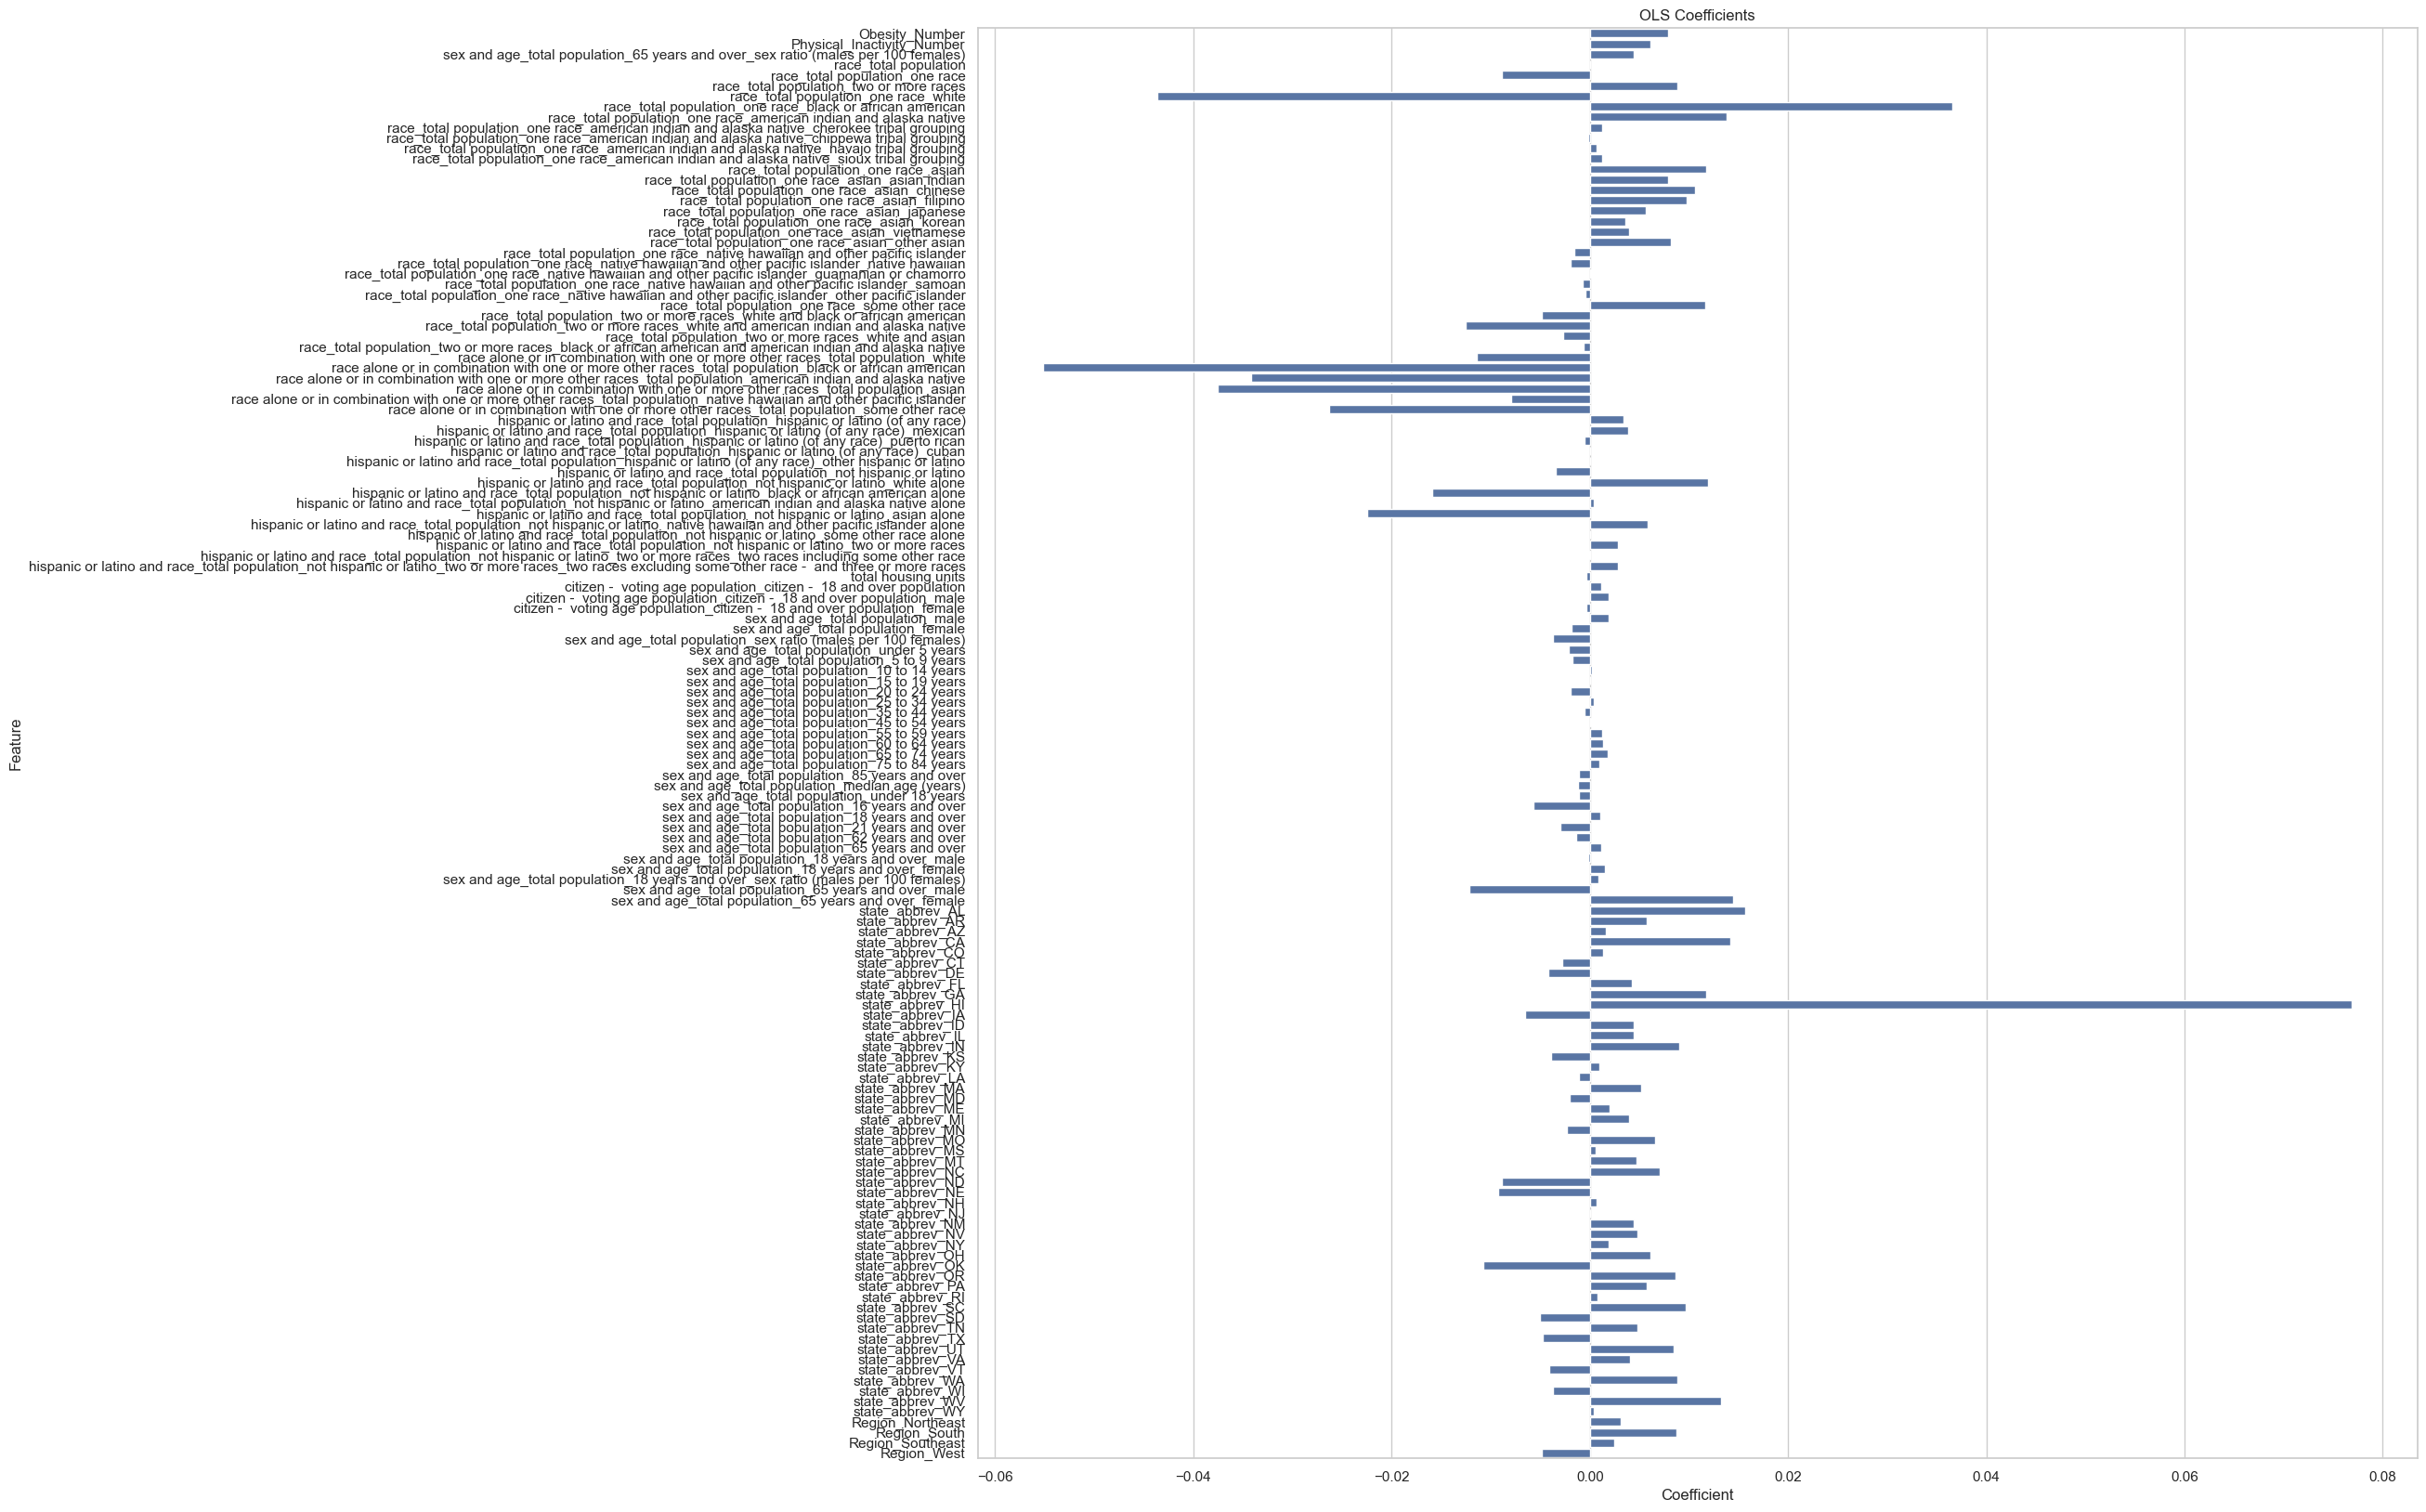

In [151]:
#
# Model 1 training


lin_reg = LinearRegression()

lin_model = lin_reg.fit(X_train, y_train)

lin_reg_data = pd.DataFrame([lin_model.coef_, X.columns]).T # make a dataframe from the arrays
lin_reg_data.columns = ['Coefficient', 'Feature']           # add column names for clarity
lin_reg_training_pred=lin_model.predict(X_train)

# plot
ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=lin_reg_data)                         # specify data

ax.set_title("OLS Coefficients")                            # set title
plt.show()               

In [152]:
# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [153]:
def adj_r2(pred, actual,p):
    tss=np.sum((actual-np.mean(actual))**2)
    rss=np.sum((actual-pred)**2)
    r2=(1-rss/tss)
    n=len(actual)
    adj_r2=1 - (1 - r2) * (n - 1) / (n - p - 1)
    return adj_r2

In [154]:
LM_training_rmse=rmse(lin_reg_training_pred,y_train)
print("Linear Model RMSE:",LM_training_rmse)
LM_training_adj_r2=adj_r2(pred=lin_reg_training_pred,actual=y_train,p=X_train.shape[1])
print("Linear Model Adj R^2:",LM_training_adj_r2)

Linear Model RMSE: 0.019094383539346033
Linear Model Adj R^2: 0.5286431280951283


#### Model 2:  (Ridge Regression (L2 penalized OLS)) 

In [155]:
#
# Model 2 training
#-----------
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']  
ridge_training_pred=ridge_model.predict(X_train)

Ridge_training_rmse=rmse(ridge_training_pred,y_train)
print("Ridge Model RMSE:",Ridge_training_rmse)
Ridge_training_adj_r2=adj_r2(pred=ridge_training_pred,actual=y_train,p=X_train.shape[1])
print("Ridge Model Adj R^2:",Ridge_training_adj_r2)


Ridge Model RMSE: 0.019114461056559715
Ridge Model Adj R^2: 0.5276513546596383


#### Model 3:  (Lasso (L1 penalized OLS)) 

In [156]:
#
# Model 3 training
#-----------
lasso_reg = Lasso(alpha=0.001)                                              # create the model
lasso_model = lasso_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']  

lasso_training_pred=lasso_model.predict(X_train)

Lasso_training_rmse=rmse(lasso_training_pred,y_train)
print("Lasso Model RMSE:",Lasso_training_rmse)
Lasso_training_adj_r2=adj_r2(pred=lasso_training_pred,actual=y_train,p=X_train.shape[1])
print("Lasso Model Adj R^2:",Lasso_training_adj_r2)


Lasso Model RMSE: 0.020409491763408227
Lasso Model Adj R^2: 0.461478632918943


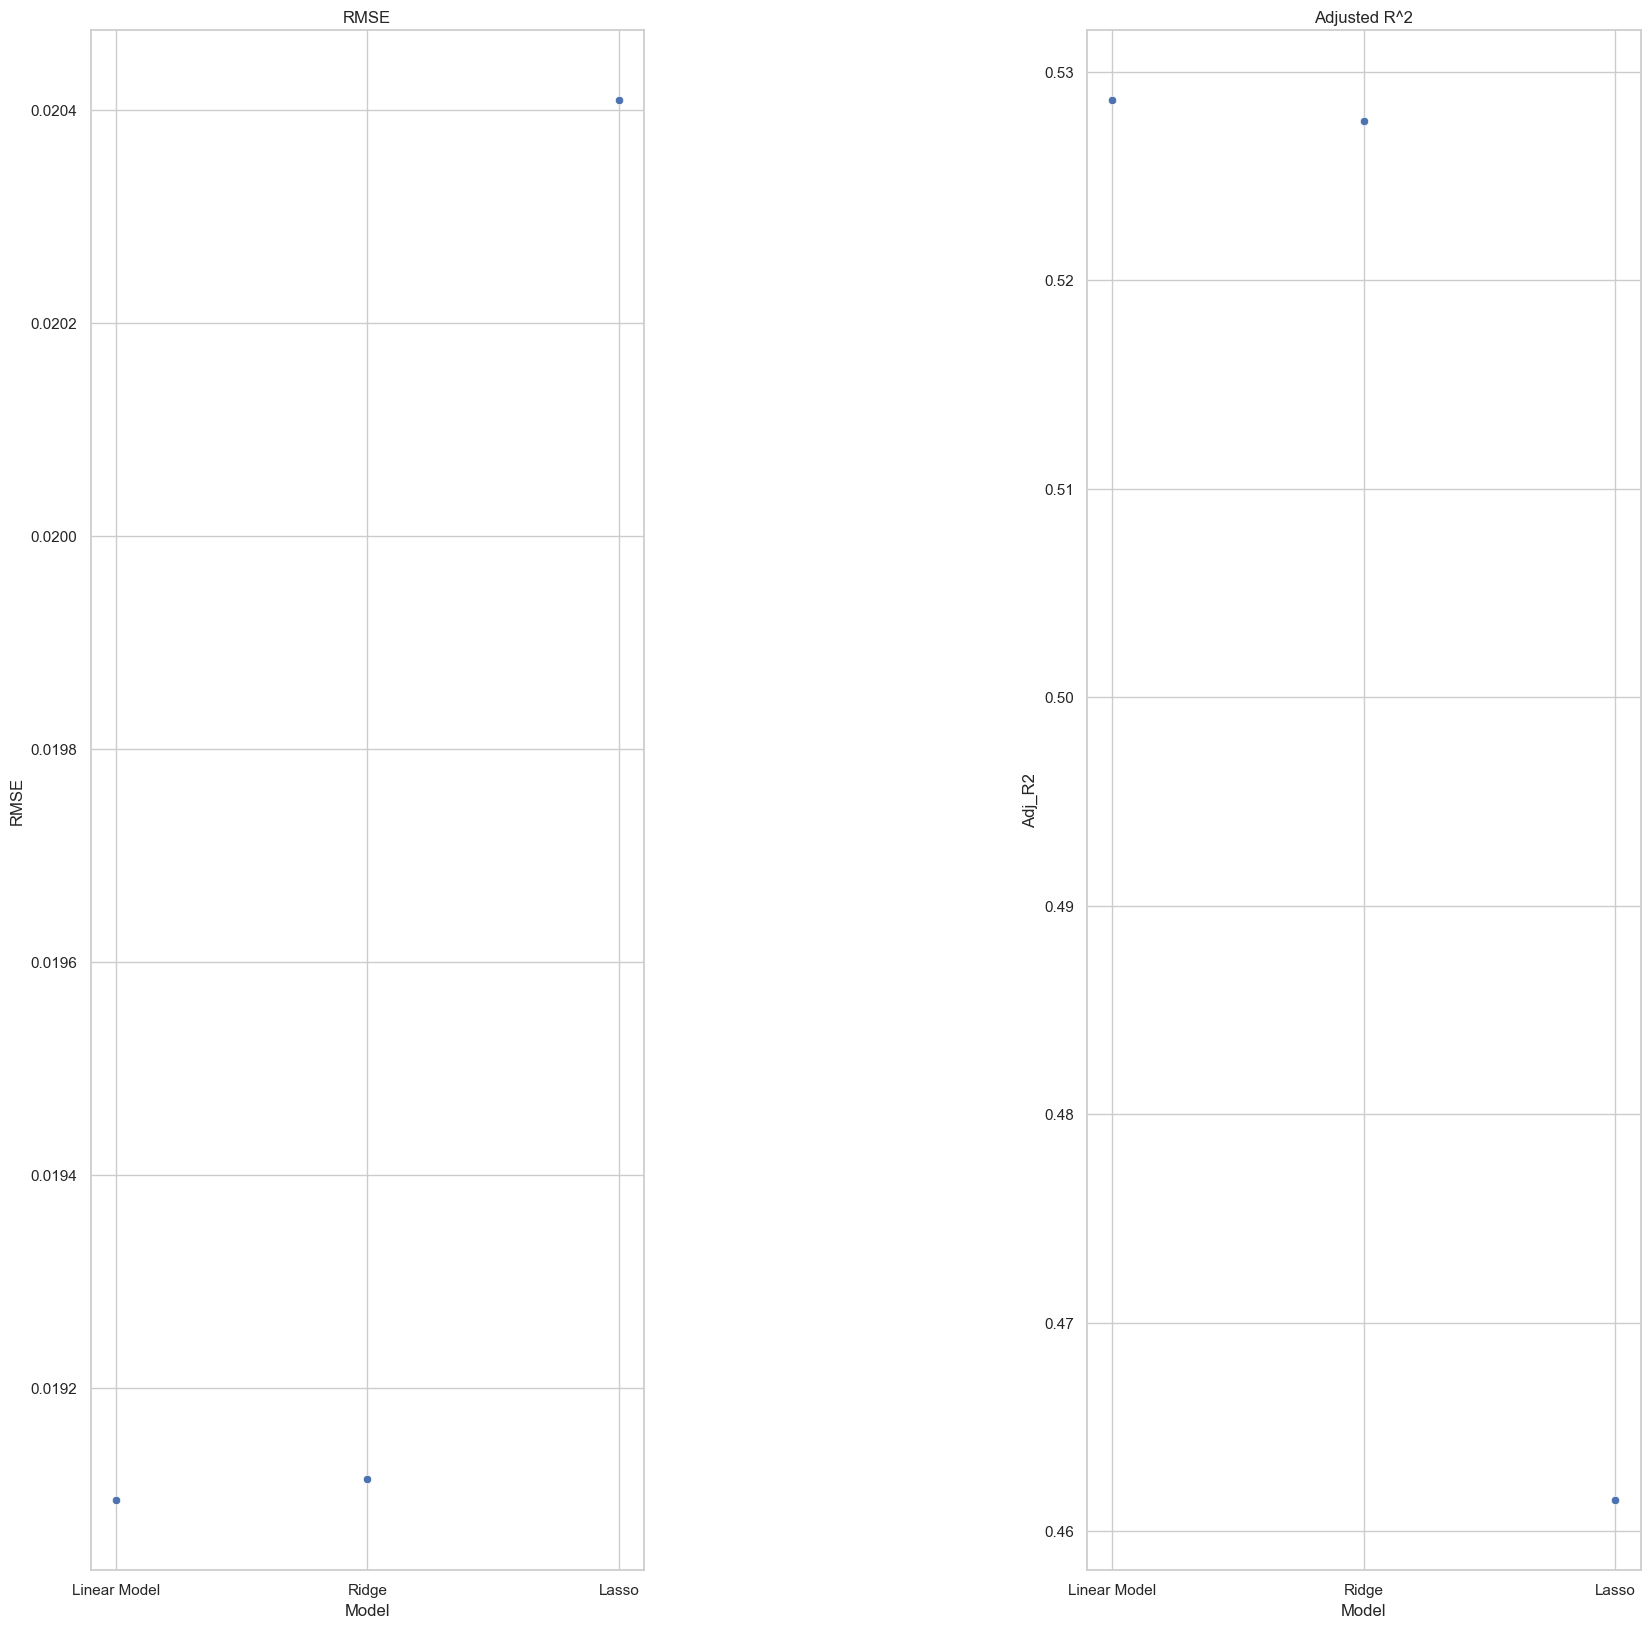

In [157]:
training_metrics = {
    'Model': ['Linear Model', 'Ridge', 'Lasso'],
    'RMSE': [LM_training_rmse, Ridge_training_rmse,Lasso_training_rmse],
    'Adj_R2': [LM_training_adj_r2,Ridge_training_adj_r2,Lasso_training_adj_r2]
}
# set the figure parameters
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .8, hspace=.5)   # adjust the space in between figures 
# plot 1
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   1)   # specifies the following code is for the first plot  
sns.scatterplot(x="Model", 
            y="RMSE", 
            data=training_metrics).set_title("RMSE")
# plot 2
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   2)   # specifies the following code is for the second plot 
sns.scatterplot(x="Model", 
            y="Adj_R2", 
            data=training_metrics).set_title("Adjusted R^2")
plt.show()

In the training data, the Lasso is the worst performing model on both of our metrics, root mean squared error and adjusted R^2. The linear model performed the best, while the ridge was mildly worse than the linear model and much better than the lasso. This is to be expected for in-sample performance, as the linear model's loss function is unpenalized, allowing it to possibly overfit the training data. For the two regularized models, we have traded some bias in the training sample performance with the penalties, with the hope that this will result in lower variance and better out-of-sample performance. 

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

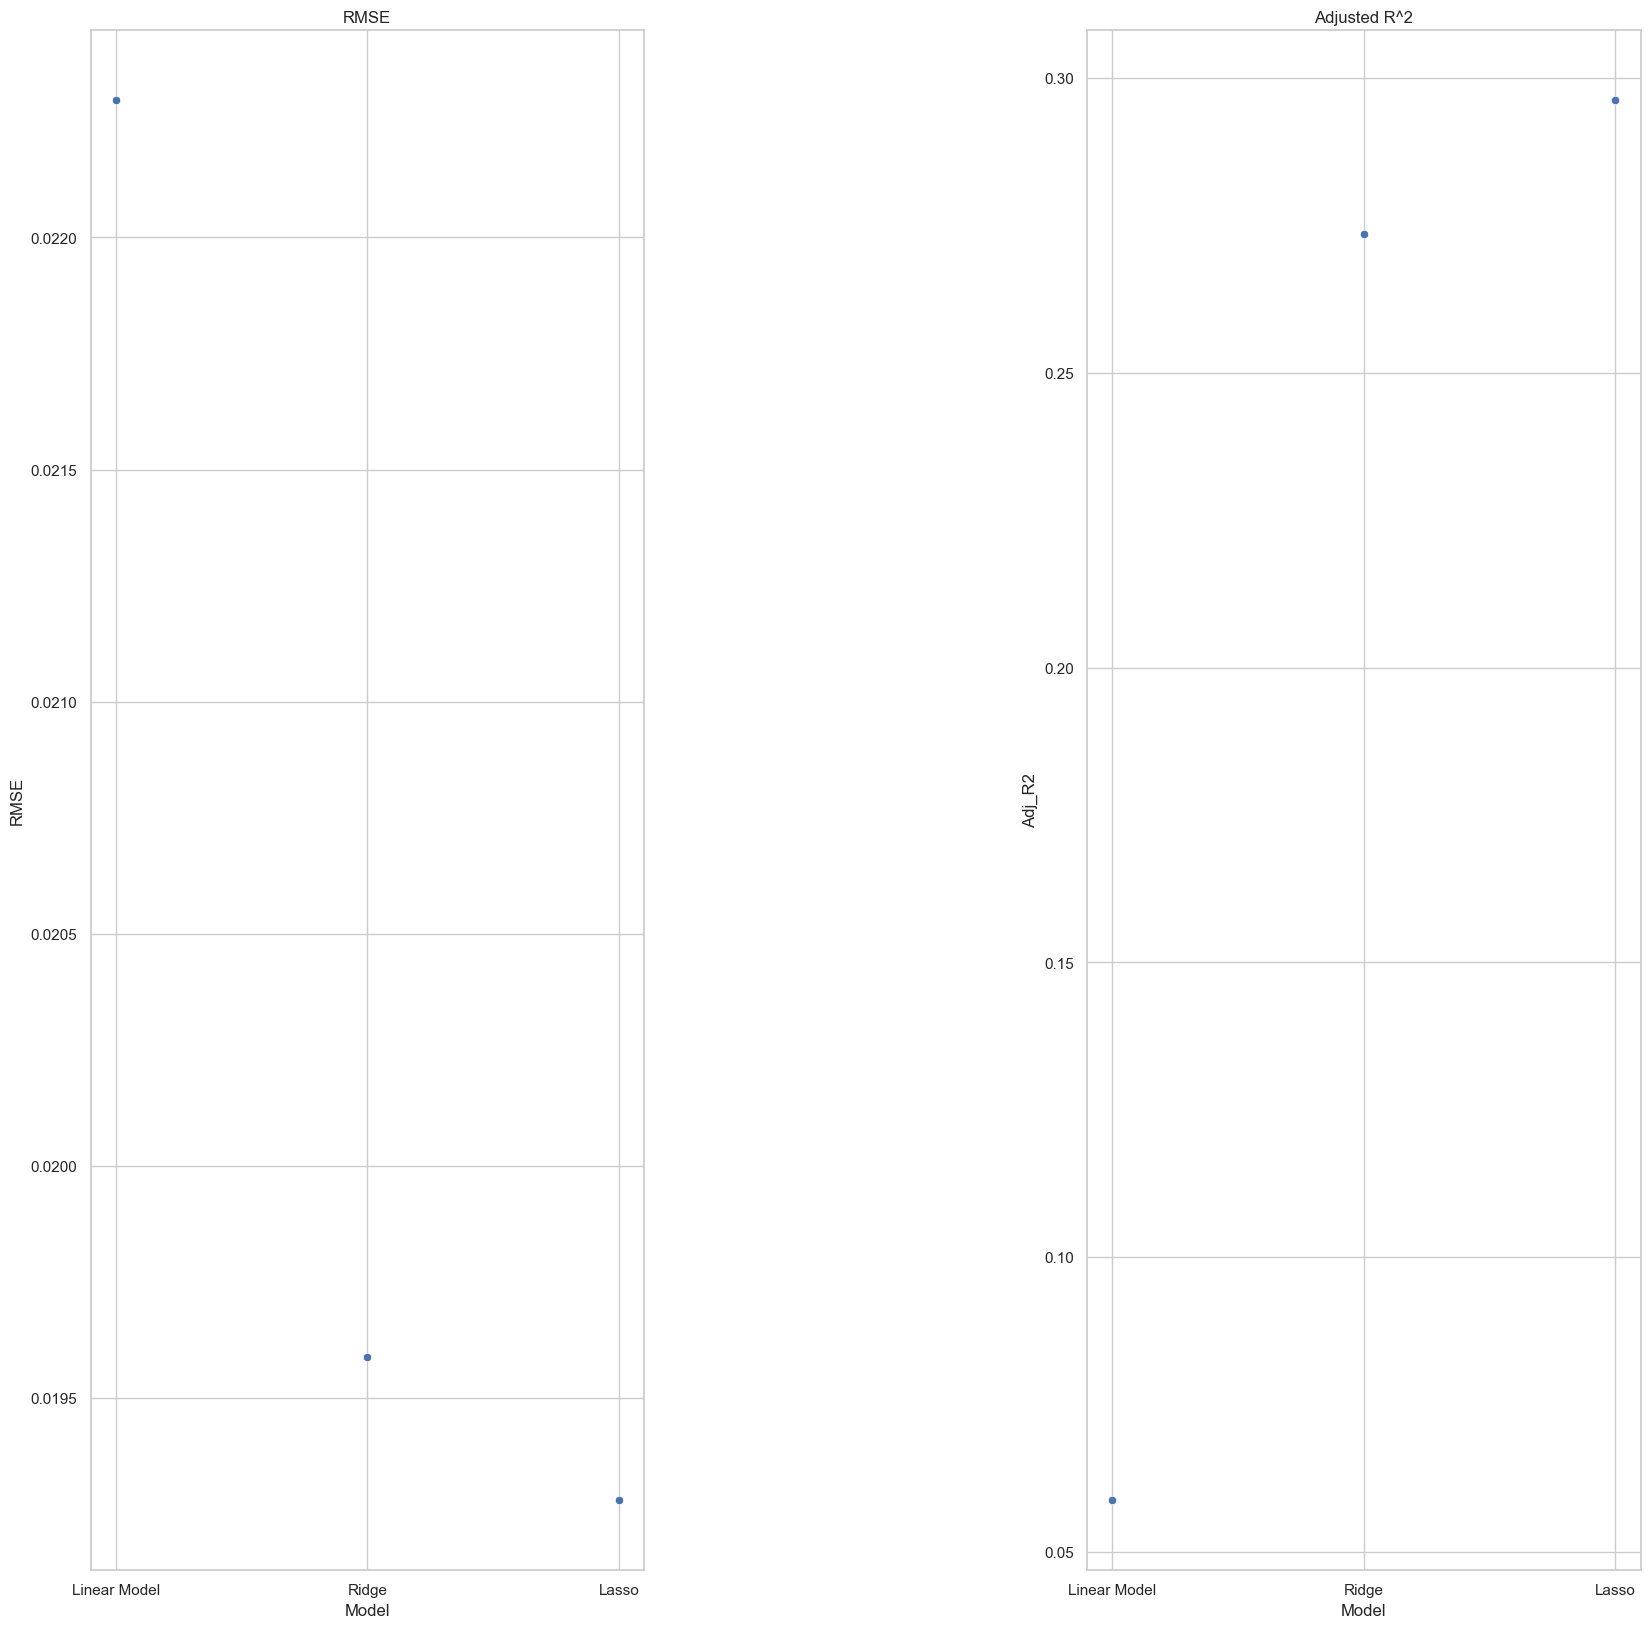

In [158]:
#
# Predict on validation data
#-----------
linear_reg_val_pred=lin_model.predict(X_validate)
lm_val_rmse=rmse(pred=linear_reg_val_pred,actual=y_validate)
lm_val_adj_r2=adj_r2(pred=linear_reg_val_pred,actual=y_validate,p=X_train.shape[1])

ridge_val_pred=ridge_model.predict(X_validate)
ridge_val_rmse=rmse(pred=ridge_val_pred,actual=y_validate)
ridge_val_adj_r2=adj_r2(pred=ridge_val_pred,actual=y_validate,p=X_train.shape[1])

lasso_val_pred=lasso_model.predict(X_validate)
lasso_val_rmse=rmse(pred=lasso_val_pred,actual=y_validate)
lasso_val_adj_r2=adj_r2(pred=lasso_val_pred,actual=y_validate,p=X_train.shape[1])

val_metrics = {
    'Model': ['Linear Model', 'Ridge', 'Lasso'],
    'RMSE': [lm_val_rmse, ridge_val_rmse,lasso_val_rmse],
    'Adj_R2': [lm_val_adj_r2,ridge_val_adj_r2,lasso_val_adj_r2]
}
# set the figure parameters
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .8, hspace=.5)   # adjust the space in between figures 
# plot 1
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   1)   # specifies the following code is for the first plot  
sns.scatterplot(x="Model", 
            y="RMSE", 
            data=val_metrics).set_title("RMSE")
# plot 2
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   2)   # specifies the following code is for the second plot 
sns.scatterplot(x="Model", 
            y="Adj_R2", 
            data=val_metrics).set_title("Adjusted R^2")
plt.show()

In the validation data, the Lasso is the best performing model on both of our metrics, root mean squared error and adjusted R^2. The linear model performed the worst, while the ridge was better than the linear model and worse than the lasso. This is fits our hopes and expectations for out-of-sample performance, as the linear model's loss function is unpenalized, allowing it to possibly overfit the training data. For the two regularized models, we have traded some bias in the training sample performance with the penalties, getting lower variance and better out-of-sample performance in return. The better performance of lasso over ridge here is in part due to the values we chose for alpha (the scalar for the penalty), so with different values of alpha these results may not be the same, and the linear model could still outperform the other two out-of-sample. 

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [159]:
#
# Predict using your best model
#-----------
lasso_test_pred=lasso_model.predict(X_test)
lasso_test_rmse=rmse(pred=lasso_test_pred,actual=y_test)
lasso_test_adj_r2=adj_r2(pred=lasso_test_pred,actual=y_test,p=X_train.shape[1])
print("Best Model (Lasso) RMSE:", lasso_test_rmse)
print("Best Model (Lasso) Adjusted R&2:", lasso_test_adj_r2)

Best Model (Lasso) RMSE: 0.02060314739286641
Best Model (Lasso) Adjusted R&2: 0.2833211602497212


### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [160]:
#
# Run cross-validation
#-----------
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#re-combining training and val data as gridsearch cv will create its own val sets
X_train_CV=pd.concat([X_train,X_validate],ignore_index=True)
y_train_CV=pd.concat([y_train,y_validate],ignore_index=True)

scoring = ['r2', 'neg_mean_squared_error']

lasso_reg=Lasso(max_iter=10000)
param_grid = {'alpha': np.r_[0.0001, np.arange(0.001, 0.01, 0.001)],
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

# execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=5,
                              scoring=scoring,
                              refit='neg_mean_squared_error')

# now fit the tuning on the training data
lasso_grid_reg.fit(X_train_CV, y_train_CV)

# select the best performing model and predict with that on validation dataset 
best_lasso_coef = lasso_grid_reg.best_estimator_.coef_
coef_selected=X_train.columns[best_lasso_coef!=0]
lasso_results_df = pd.DataFrame(lasso_grid_reg.cv_results_)
lasso_best_index = lasso_grid_reg.best_index_
lasso_grid_regmean_mse_best = -lasso_results_df.loc[lasso_best_index, 'mean_test_neg_mean_squared_error']
lasso_grid_regmean_r2_best = lasso_results_df.loc[lasso_best_index, 'mean_test_r2']
#subset X_train to just the coefficients the best performing Lasso selected
X_train_CV_subset=X_train_CV[coef_selected]
#see if the resulting relaxed fits for LM and Ridge can out compete Lasso on the narrower data
#CV the LM
lin_reg=LinearRegression()
param_grid = {'fit_intercept': [True, False]} 
lin_grid_reg = GridSearchCV(estimator  = lin_reg,
                            param_grid = param_grid,   
                            cv=5,
                            scoring=scoring,
                            refit='neg_mean_squared_error')
lin_grid_reg.fit(X_train_CV_subset, y_train_CV)
lin_results_df = pd.DataFrame(lin_grid_reg.cv_results_)
lin_best_index = lin_grid_reg.best_index_
lin_grid_regmean_mse_best = -lin_results_df.loc[lin_best_index, 'mean_test_neg_mean_squared_error']
lin_grid_regmean_r2_best = lin_results_df.loc[lin_best_index, 'mean_test_r2']
#Fit LM again with full X
lin_reg_full=LinearRegression()
param_grid = {'fit_intercept': [True, False]} 
lin_grid_reg_full = GridSearchCV(estimator  = lin_reg_full,
                            param_grid = param_grid,   
                            cv=5,
                            scoring=scoring,
                            refit='neg_mean_squared_error')
lin_grid_reg_full.fit(X_train_CV, y_train_CV)
lin_full_results_df = pd.DataFrame(lin_grid_reg_full.cv_results_)
lin_full_best_index = lin_grid_reg_full.best_index_
lin_full_grid_regmean_mse_best = -lin_full_results_df.loc[lin_full_best_index, 'mean_test_neg_mean_squared_error']
lin_full_grid_regmean_r2_best = lin_full_results_df.loc[lin_full_best_index, 'mean_test_r2']
# CV the Ridge
ridge_reg=Ridge()
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}
ridge_grid_reg = GridSearchCV(ridge_reg, 
                              param_grid, 
                              cv=5,
                              scoring=scoring,
                              refit='neg_mean_squared_error')   
ridge_grid_reg.fit(X_train_CV_subset, y_train_CV)
ridge_results_df = pd.DataFrame(ridge_grid_reg.cv_results_)
ridge_best_index = ridge_grid_reg.best_index_
ridge_grid_regmean_mse_best = -ridge_results_df.loc[ridge_best_index, 'mean_test_neg_mean_squared_error']
ridge_grid_regmean_r2_best = ridge_results_df.loc[ridge_best_index, 'mean_test_r2']
#fit ridge again with full X
ridge_reg_full=Ridge()
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}
ridge_grid_reg_full = GridSearchCV(ridge_reg_full, 
                              param_grid, 
                              cv=5,
                              scoring=scoring,
                              refit='neg_mean_squared_error')   
ridge_grid_reg_full.fit(X_train_CV, y_train_CV)
ridge_full_results_df = pd.DataFrame(ridge_grid_reg_full.cv_results_)
ridge_full_best_index = ridge_grid_reg_full.best_index_
ridge_full_grid_regmean_mse_best = -ridge_full_results_df.loc[ridge_full_best_index, 'mean_test_neg_mean_squared_error']
ridge_full_grid_regmean_r2_best = ridge_full_results_df.loc[ridge_full_best_index, 'mean_test_r2']


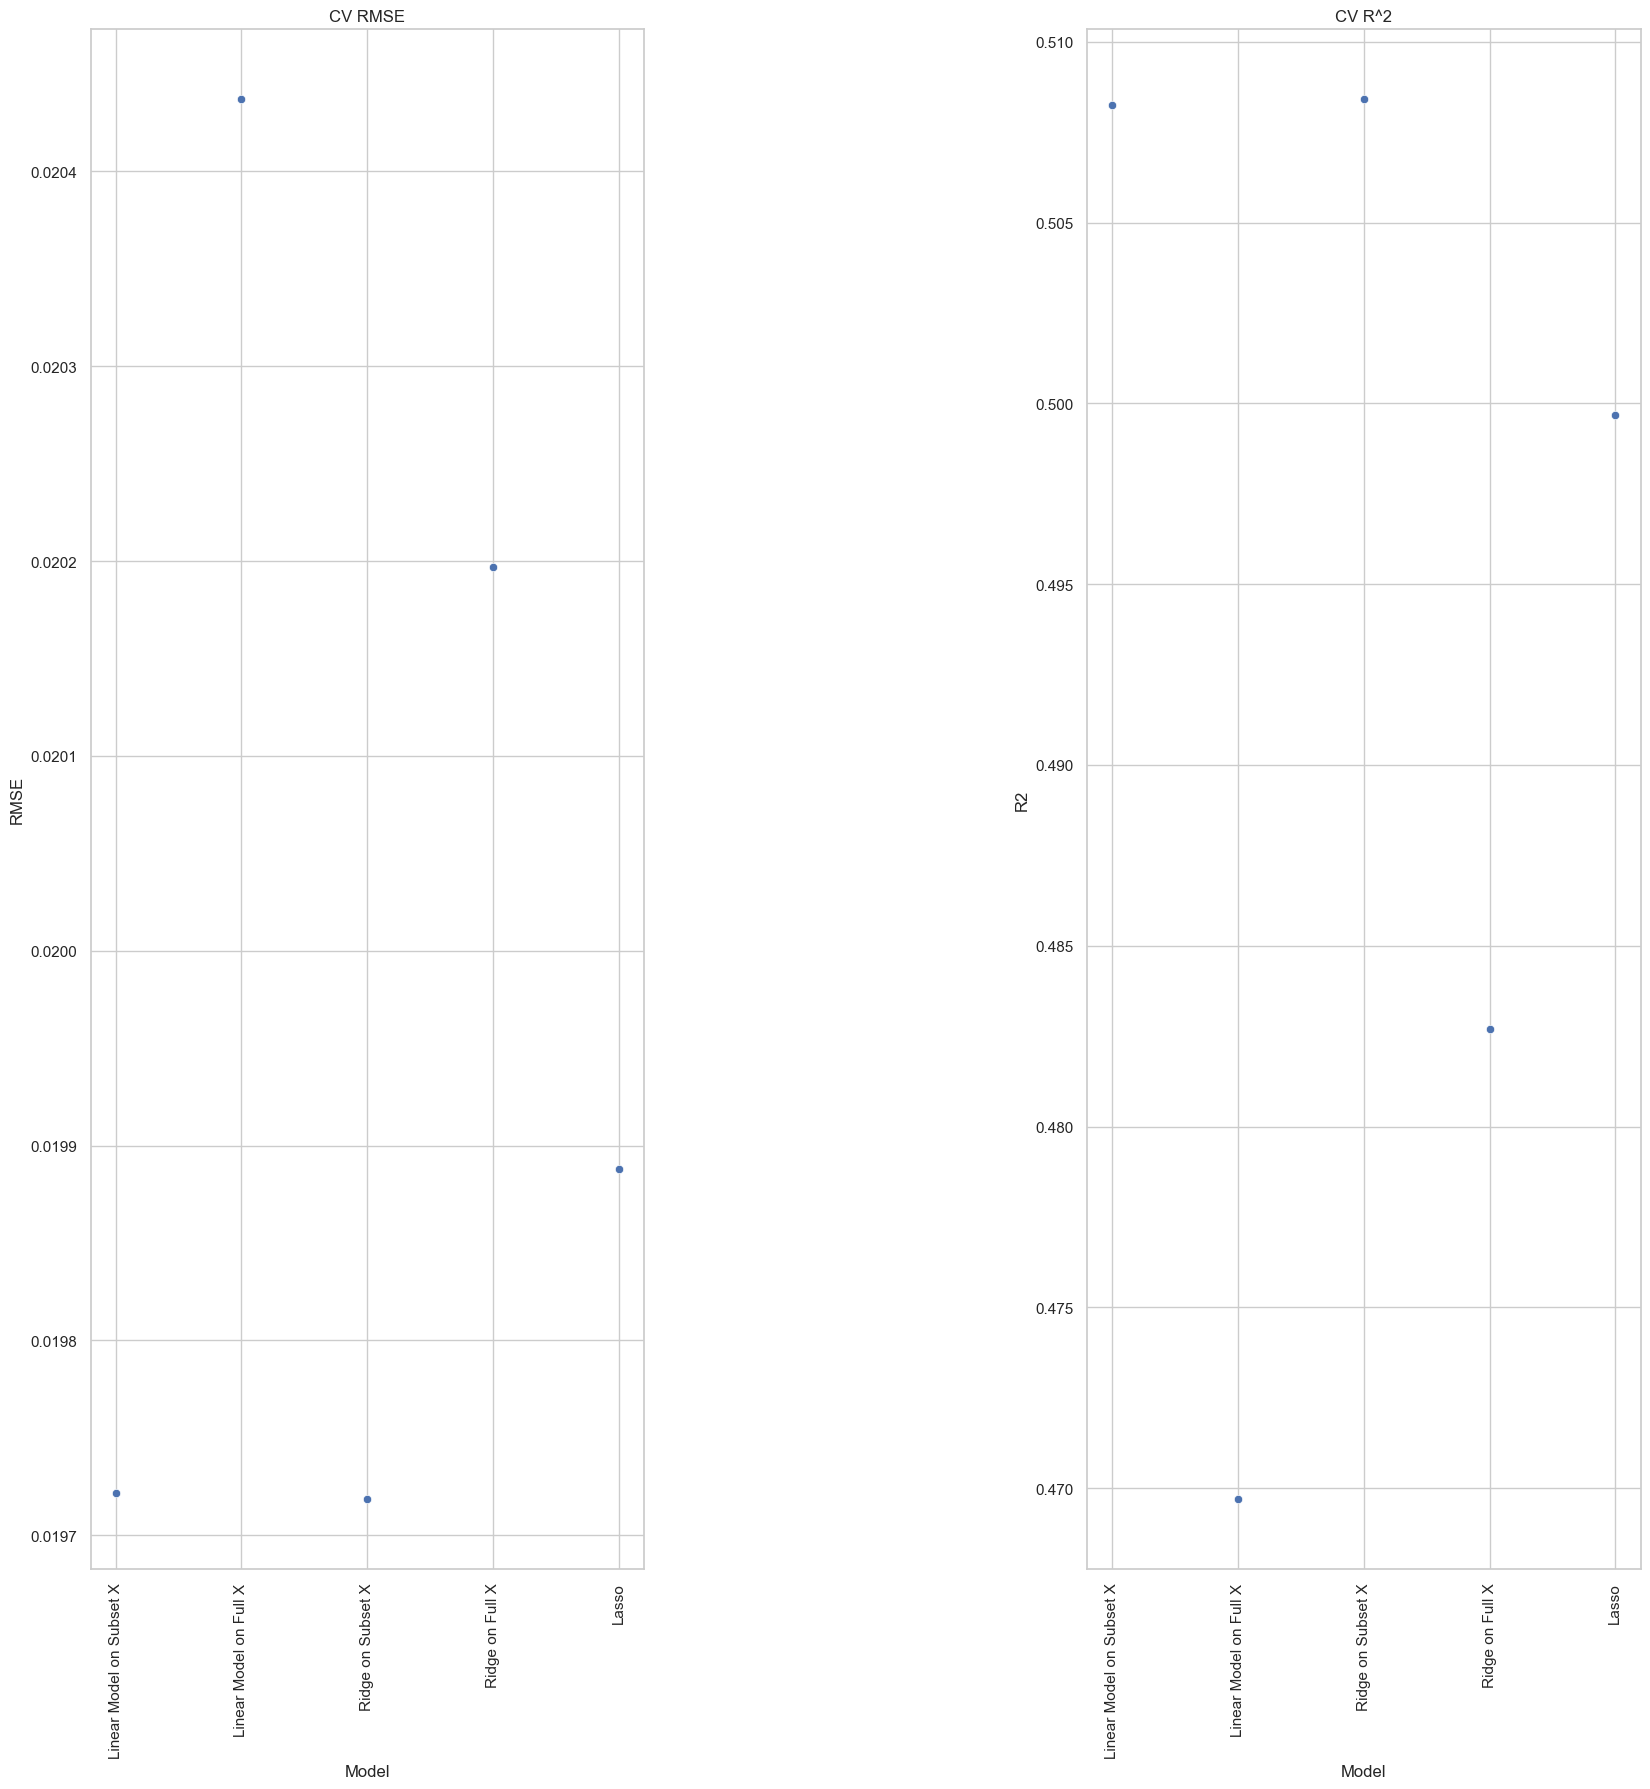

In [161]:
CV_metrics = pd.DataFrame({
    'Model': ['Linear Model on Subset X','Linear Model on Full X', 'Ridge on Subset X','Ridge on Full X', 'Lasso'],
    'MSE': [lin_grid_regmean_mse_best,lin_full_grid_regmean_mse_best,
            ridge_grid_regmean_mse_best,ridge_full_grid_regmean_mse_best,lasso_grid_regmean_mse_best],
    'R2': [lin_grid_regmean_r2_best,lin_full_grid_regmean_r2_best,
               ridge_grid_regmean_r2_best,ridge_full_grid_regmean_r2_best,lasso_grid_regmean_r2_best]
})
CV_metrics["RMSE"]=np.sqrt(CV_metrics["MSE"])
# set the figure parameters
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .8, hspace=.5)   # adjust the space in between figures 
# plot 1
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   1)   # specifies the following code is for the first plot  
sns.scatterplot(x="Model", 
            y="RMSE", 
            data=CV_metrics).set_title("CV RMSE")
plt.xticks(rotation=90)
# plot 2
# ----------
figure.add_subplot(1,   # sets the number of rows
                   2,   # sets columns,
                   2)   # specifies the following code is for the second plot 
sns.scatterplot(x="Model", 
            y="R2", 
            data=CV_metrics).set_title("CV R^2")
plt.xticks(rotation=90)
plt.show()

In [459]:
min_RMSE = CV_metrics['RMSE'].min()
subset_df = CV_metrics[CV_metrics['RMSE'] == min_RMSE]
print("Best model by CV RMSE was:",subset_df["Model"].to_string(index=False))
#print(subset_df['Model'])
best_CV_estimator_test_pred = ridge_grid_reg.best_estimator_.predict(X_test[coef_selected])
print('Test RMSE', rmse(best_CV_estimator_test_pred, y_test))
print('Test Adjusted R^2', adj_r2(best_CV_estimator_test_pred, y_test,X_train_CV_subset.shape[1]))

Best model by CV RMSE was: Ridge on Subset X
Test RMSE 0.02024493737369892
Test Adjusted R^2 0.4173475546278017


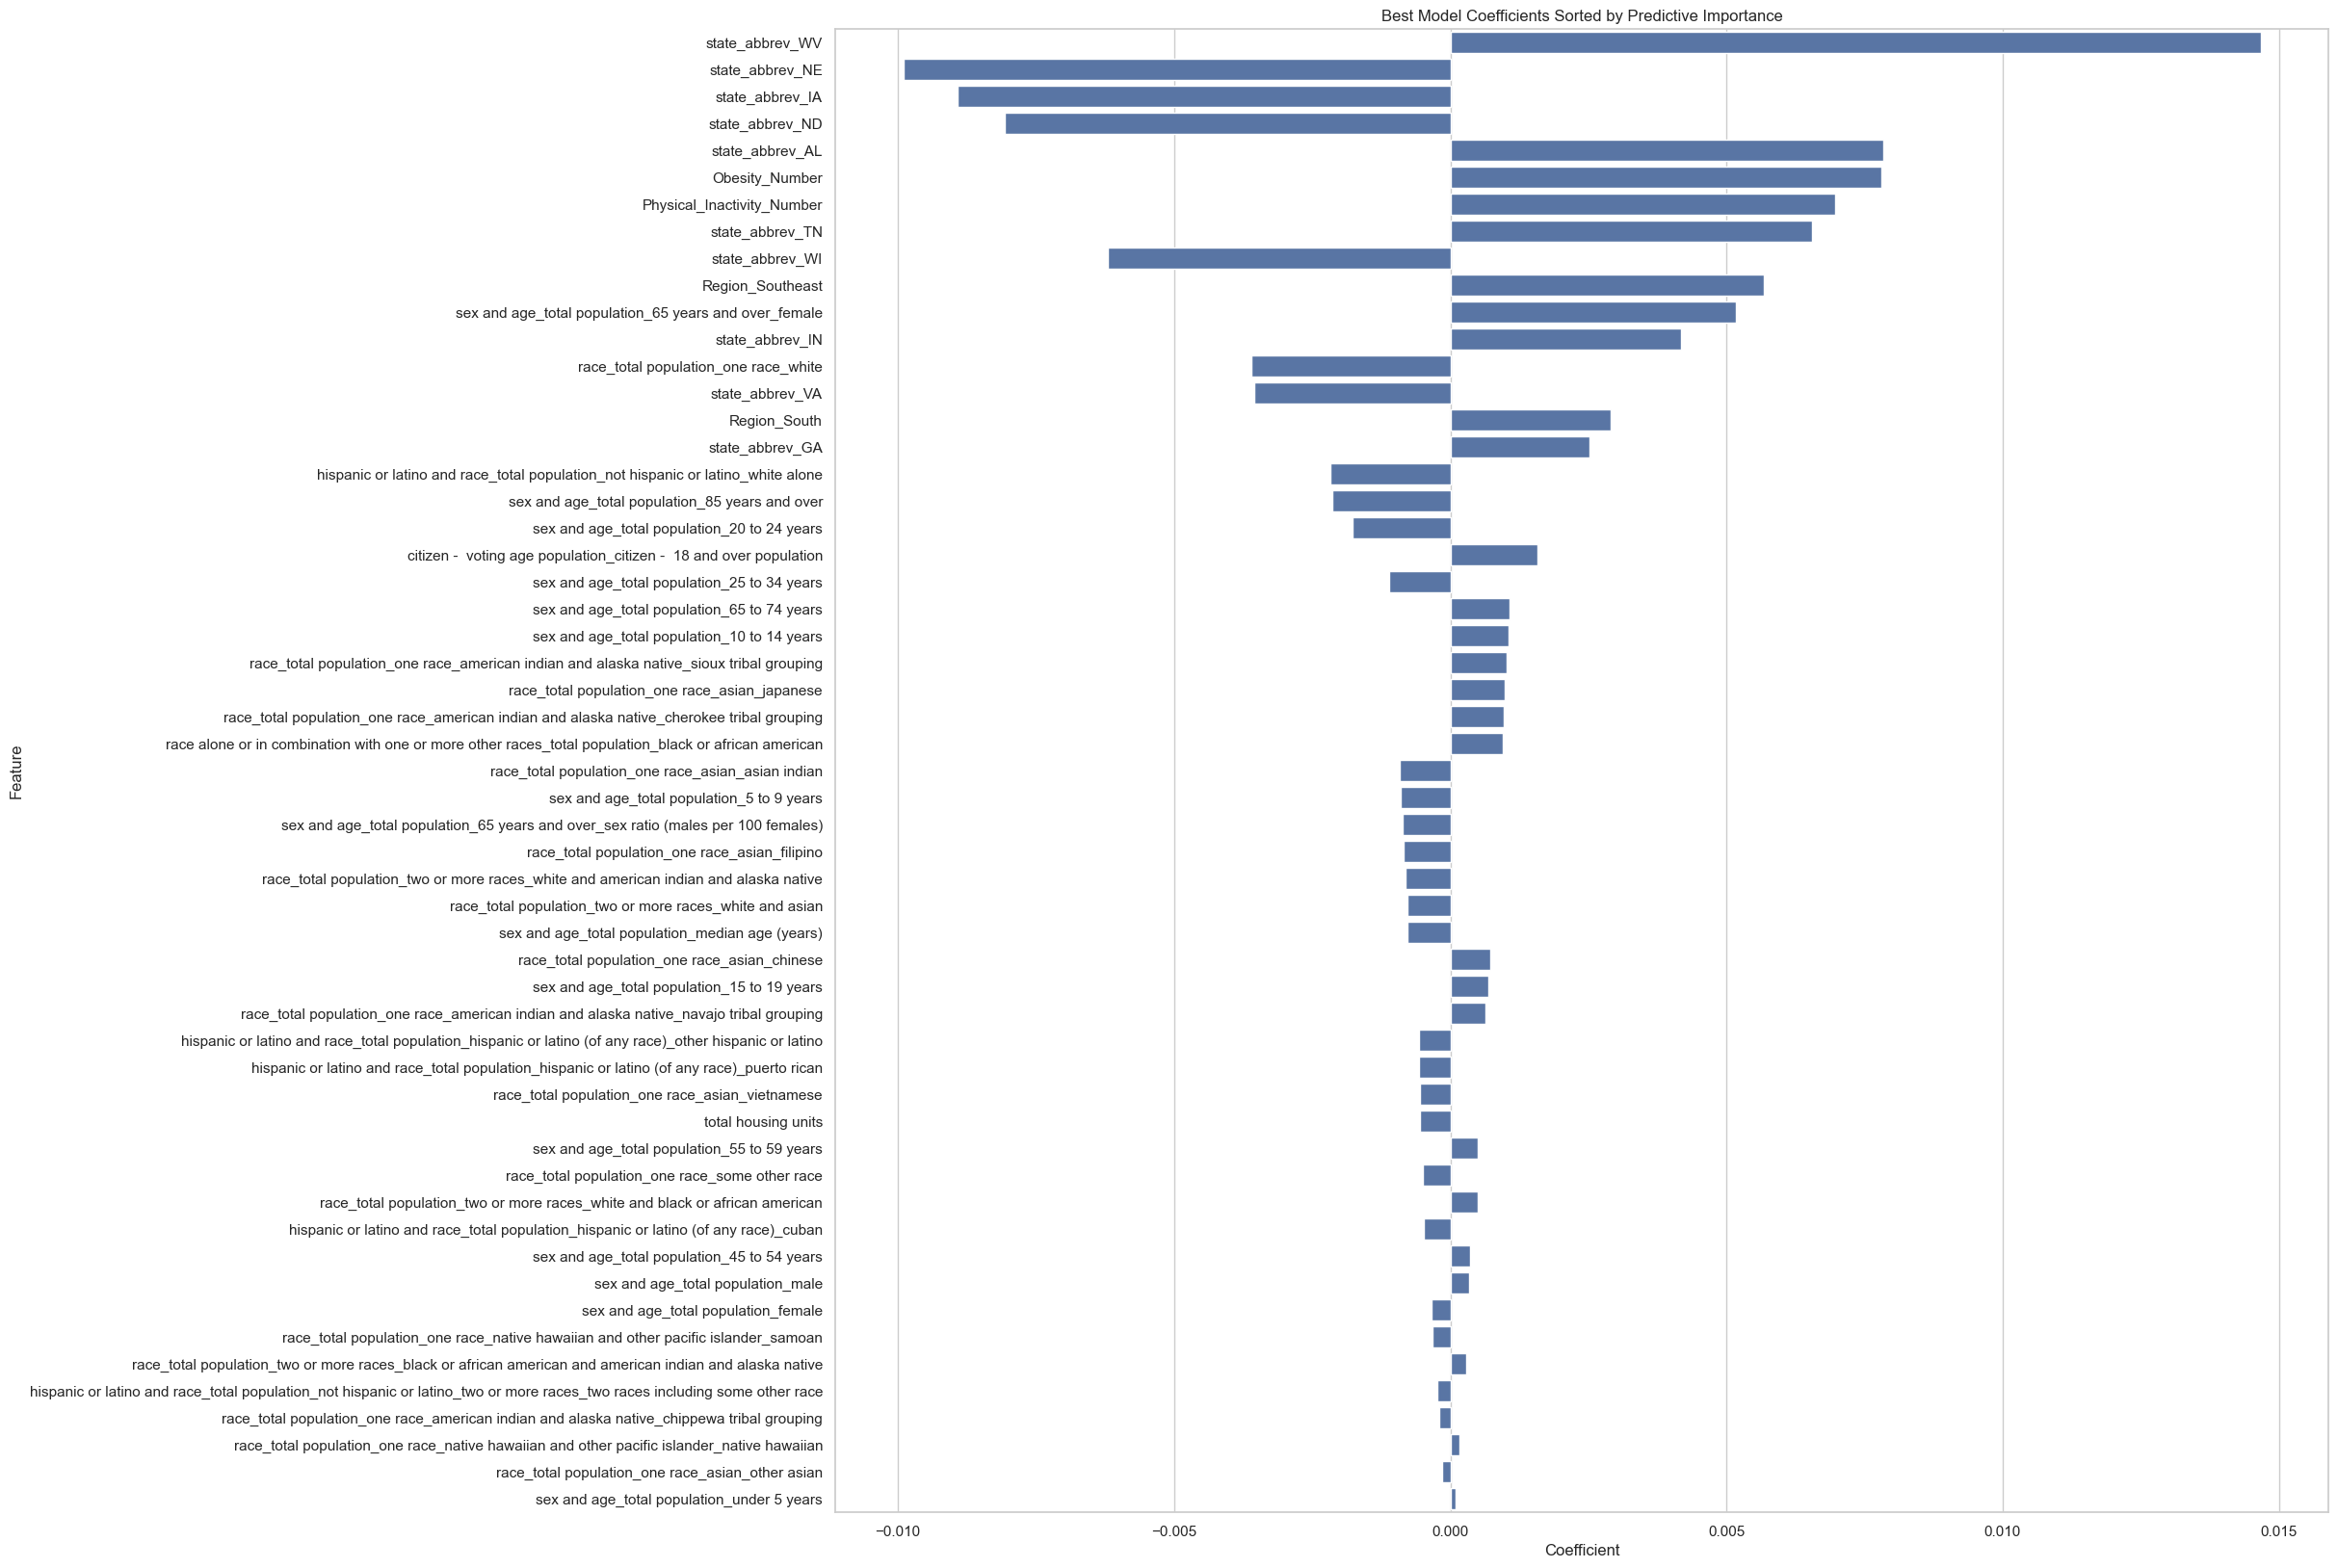

In [166]:
best_model_data = pd.DataFrame([ridge_grid_reg.best_estimator_.coef_, coef_selected]).T # make a dataframe from the arrays
best_model_data.columns = ['Coefficient', 'Feature']           # add column names for clarity
best_model_data_top=best_model_data.sort_values(by='Coefficient',ascending=False,key=abs)
best_model_data_top
# plot
ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=best_model_data_top)                         # specify data

ax.set_title("Best Model Coefficients Sorted by Predictive Importance")                            # set title
plt.show() 

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

*Bias*: For the quantitative researcher, ‘bias’ has to do with error arising from approximation (James et al., 2020). Bias indicates that the sample is unrepresentative of a population (Crawford, 2021). Fortunately for the researcher, bias is measurable (Christian, 2020).

*Variance*: In classical statistics, variance is  a measure of spread. When the variance is large, the data is more spread out—that is to say, entries’ values are further from the mean (Moore et al., 2009). Like standard deviation, variance measures dispersion. In a machine learning context, variance indicates how $\hat{f}$ changes when the researcher(s) uses different data (James et al., 2023).

*Relationship between bias and variance*: A model with more bias will have a lower variance and vice versa. The more flexible our methods, the higher the variance (and lower the bias) (James et al., 2023). Initially with greater methodological flexibility, the bias’ decrease surpasses the variance’s increase; accordingly, we find a decrease in expected test MSE. However, eventually the greater flexibility will decrease the bias less and increase the variance more; accordingly, we find an increase in expected test MSE.

*Bias-variance tradeoff*: Ideally, a researcher’s test set will have low variance and low squared bias. In practice this may not be possible. Low bias but high variance, high bias but low variance—these are achievable easily. However, the researcher desires neither overfitting nor underfitting. In a Faustian bargain, the researcher must decide how to balance bias and variance to achieve the leas- bad result.

*Why it’s relevant to machine learning problems like this one*: Machine learning projects will often use a high number of parameters; accordingly, high variance may be a consequence. To resolve the negative consequences of high variance, we may “trade” some variance by accepting increased bias (Lundberg et al, 2022, p. 8). In situations with high variance in an unbiased estimator, the bias-variance tradeoff matters (Lundberg et al., 2022). Ridge regression can be more effective in reducing variance than least squares (James et al., 2023, p. 242). 


2. Define overfitting, and why it matters for machine learning. How can we address it?

*Overfitting*: In overfitting, a model fits the particular data well. Almost too well. An overfit model will not predict output for new inputs effectively. With overfitting, “we capture not just the signal, but also the noise (Molina & Garip, 2019, p. 30). Our estimate of accuracy will be biased (Breiman, 2001). Of particular consequence for researchers, an overfit model will not be useful for generalization. We discussed a few causes of overfitting, including using many parameters in a model (Breiman, 2001), high variance models, and large search space (James et al., 2023, p. 233)

*Why it matters for machine learning*: Ironically, what makes machine learning powerful can lead to problems; machine learning models tend to overfit their training data. As a prophilactic, researchers can use data splitting before training a model. For larger datasets, we may use a test set (Breiman, 2001). To reduce bias and increase predictive accuracy, we may use cross-validation. In cross-validation, the test set will allow every data point once, and average the error (Breiman, 2001; Molina & Garip, 2019). Consequently, variation in random sample proves less influential to the model.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

The ridge regression using the coefficients that the lasso selected had the best performance out of all the tested models with a test RMSE of 0.02 and an adjusted $R^2$ of 0.42. According to the ridge regression using the subsetted coefficients, the South and Southeast regions are associated with higher rates of diabetes, especially the states of West Virginia, Alabama, Tennessee, and Indiana. In contrast, the states of Iowa, North Dakota, Nebraska, and Wisconsin are negatively associated with rates of diabetes. As suggested earlier in the scatterplot, the ridge regression confirmed that obesity and physical inactivity are quite predictive of higher rates of diabetes. The model also suggests that female-identifying people who are 65 years old and higher are more likely to experience diabetes. Among all racial demographic groups, people who identify as American Indian/Alaska Native, Asian, and Black seem to experience higher rates of diabetes while White people seem to be the least likely to experience diabetes.

A pilot program that aims to reduce cases of diabetes by promoting healthier diets and physically active lifestyles would ideally prioritize states in the South and Southeast regions. It would also focus on the needs of female-identifying people who are at least 65 years old, especially if they are American Indian/Native Alaska, Asian, or Black. Over time, the program would expand to account for the different needs and lifestyles of other demographic groups who are younger but could still benefit from being educated on how to build healthier lifestyles. Overall, we are fairly confident that the model shows some promising applications in identifying communities who are at greater risk of experiencing diabetes. However, the data lacks some features that would enable policymakers to better understand factors affecting the prevalence of diabetes, such as variables related to socioeconomic status and whether counties are urban or rural. Nonetheless, the model's ability to identify highly predictive features out of a plethora of variables makes it quite useful in making sense of complex phenomena as long as the data used to build it is not missing critical information.